In [1]:
import logging
import tempfile, os, sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("src")

In [2]:
data_dir = "temp_data"
working_directory = tempfile.mkdtemp()

In [3]:
aimed_xml = os.path.join(data_dir, "aimed.xml")

In [4]:
aimed_json = os.path.join(working_directory, "aimed.json")

## Convert raw xml to flattened json

In [5]:
from preprocessors.aimed_json_converter import AIMedJsonConverter

In [6]:
AIMedJsonConverter().convert_fromfile(aimed_xml, aimed_json)

In [7]:
df =  pd.read_json(aimed_json)

In [8]:
df.head()

,interacts,text,participant1Id,participant1Offset,participant1Len,participant1Text,participant2Id,participant2Offset,participant2Len,participant2Text,documentId,sentenceId,otherEntities
0,False,Cytokines measurements during IFN-alpha treatm...,AIMed.d0.s5.e0,30,9,IFN-alpha,AIMed.d0.s5.e1,89,4,IL-4,AIMed.d0,AIMed.d0.s5,[]
1,False,Levels of IFN-gamma were slightly increased fo...,AIMed.d0.s6.e0,10,9,IFN-gamma,AIMed.d0.s6.e1,54,9,IFN-alpha,AIMed.d0,AIMed.d0.s6,[]
2,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e1,65,9,IFN-gamma,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e2', 'charOffset': 109, '..."
3,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e2,109,9,IFN-alpha,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e1', 'charOffset': 65, 'l..."
4,False,In patients with a complete response to IFN-al...,AIMed.d0.s7.e0,40,9,IFN-alpha,AIMed.d0.s7.e3,186,4,IL-4,AIMed.d0,AIMed.d0.s7,"[{'id': 'AIMed.d0.s7.e1', 'charOffset': 65, 'l..."


In [9]:
df.shape

(5834, 13)

In [10]:
df.interacts.value_counts()

False    4834
True     1000
Name: interacts, dtype: int64

<AxesSubplot:ylabel='interacts'>

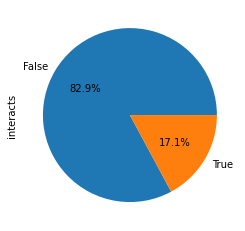

In [11]:
df.interacts.value_counts().plot.pie( autopct='%1.1f%%')

## K Fold split

In [12]:
from preprocessors.kfold_aimed_json_splitter import KFoldAimedJsonSplitter

splitter = KFoldAimedJsonSplitter()


In [13]:
def plot_k_fold_label_distibution(split_files):
    
    fig,ax = plt.subplots(1,2, figsize=(10,5) )
    
    t_all= []
    v_all = []
    for i, (t,v) in enumerate(split_files):
        t_counts = pd.read_json(t).interacts.value_counts()



        t_all.append({
            "True":t_counts[True]
            ,"False":  t_counts[False]
        }
        )


        v_counts = pd.read_json(v).interacts.value_counts()
        v_total = v_counts[True]+ v_counts[False]

        v_all.append({
            "True":v_counts[True]
            ,"False":  v_counts[False]
        }
        )

    t_df = pd.DataFrame(t_all)
    t_df["Truepercentage"]=t_df.apply(lambda r: 100 * r["True"]/(r["True"] + r["False"]), axis=1)
    t_df[["True", "False"]].plot.bar(ax= ax[0], title="Train")
        
    
    v_df= pd.DataFrame(v_all)
    v_df["Truepercentage"]=v_df.apply(lambda r: 100 * r["True"]/(r["True"] + r["False"]), axis=1)


    v_df[["True", "False"]].plot.bar(ax= ax[1], title="Validation")
    
    return t_df, v_df


### Random Split

In [14]:
random_split_dir = os.path.join(working_directory, "kfold_random")

In [15]:
random_split_files = splitter.split(aimed_json, random_split_dir, k=10, unique_doc_col=None)  

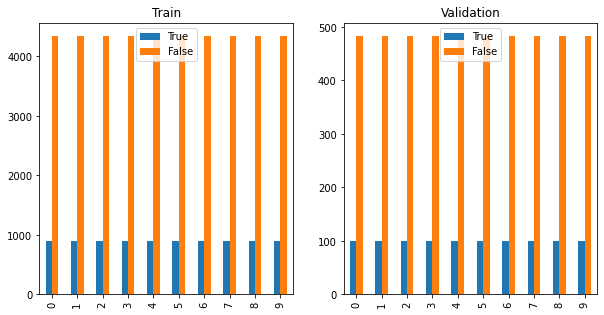

In [16]:
t_df, v_df = plot_k_fold_label_distibution(random_split_files)

In [17]:
t_df.describe()

,True,False,Truepercentage
count,10.0,10.000000,10.000000
mean,900.0,4350.600000,17.140898
std,0.0,0.516398,0.001686
min,900.0,4350.000000,17.139592
25%,900.0,4350.000000,17.139592
50%,900.0,4351.000000,17.139592
75%,900.0,4351.000000,17.142857
max,900.0,4351.000000,17.142857


In [18]:
v_df.describe()

,True,False,Truepercentage
count,10.0,10.000000,10.000000
mean,100.0,483.400000,17.140910
std,0.0,0.516398,0.015167
min,100.0,483.000000,17.123288
25%,100.0,483.000000,17.123288
50%,100.0,483.000000,17.152659
75%,100.0,484.000000,17.152659
max,100.0,484.000000,17.152659


### Unique document split

In [19]:
unique_split_dir = os.path.join(working_directory, "kfold_unique")

In [20]:
unique_split_files = splitter.split(aimed_json, unique_split_dir, k=10, unique_doc_col="documentId")  

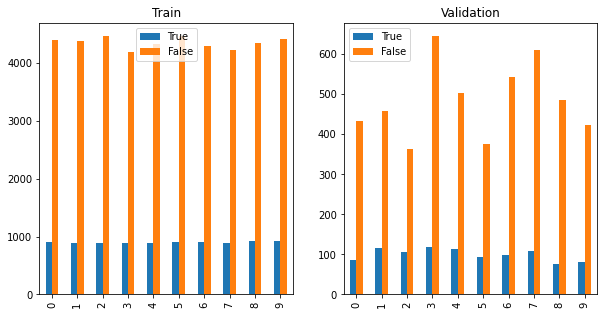

In [21]:
t_df, v_df = plot_k_fold_label_distibution(unique_split_files)

In [22]:
t_df.describe()

,True,False,Truepercentage
count,10.000000,10.000000,10.000000
mean,900.000000,4350.600000,17.143890
std,14.854853,93.704263,0.289057
min,881.000000,4189.000000,16.679091
25%,887.250000,4301.250000,16.910345
50%,899.000000,4363.000000,17.202148
75%,911.250000,4408.750000,17.383265
max,923.000000,4471.000000,17.507587


In [23]:
v_df.describe()

,True,False,Truepercentage
count,10.000000,10.000000,10.000000
mean,100.000000,483.400000,17.384428
std,14.854853,93.704263,2.796433
min,77.000000,363.000000,13.701068
25%,88.750000,425.250000,15.279773
50%,101.000000,471.000000,16.500315
75%,112.750000,532.750000,19.658606
max,119.000000,645.000000,22.435897
